In [1]:
! pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.0 MB/s eta 0:00:00


Minimum distance from liver surface to PTV center: 3.06 cm
Minimum distance from external surface to PTV center: 4.52 cm


/tmp/ipython-input-3510784286.py:127: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  t1 = np.cross(v2, v1) / dot


Mean projected distance from liver surface to PTV center: 6.60 cm
Mean projected distance from external surface to PTV center: 9.61 cm
Optimal arc candidates per rotation_range (sorted by mean liver distance):
   rotation_range  best_start_deg  best_end_deg  min_avg_liver_distance_mm  \
0             180           220.0          40.0                  40.871509   
1             190           220.0          50.0                  42.509495   
2             200           215.0          55.0                  44.321952   
3             210           210.0          60.0                  46.350050   
4             220           205.0          65.0                  48.570038   
5             230           200.0          70.0                  50.939092   

   final_external_limit_mm  
0                      120  
1                      120  
2                      120  
3                      120  
4                      120  
5                      120  


<Figure size 1200x800 with 0 Axes>

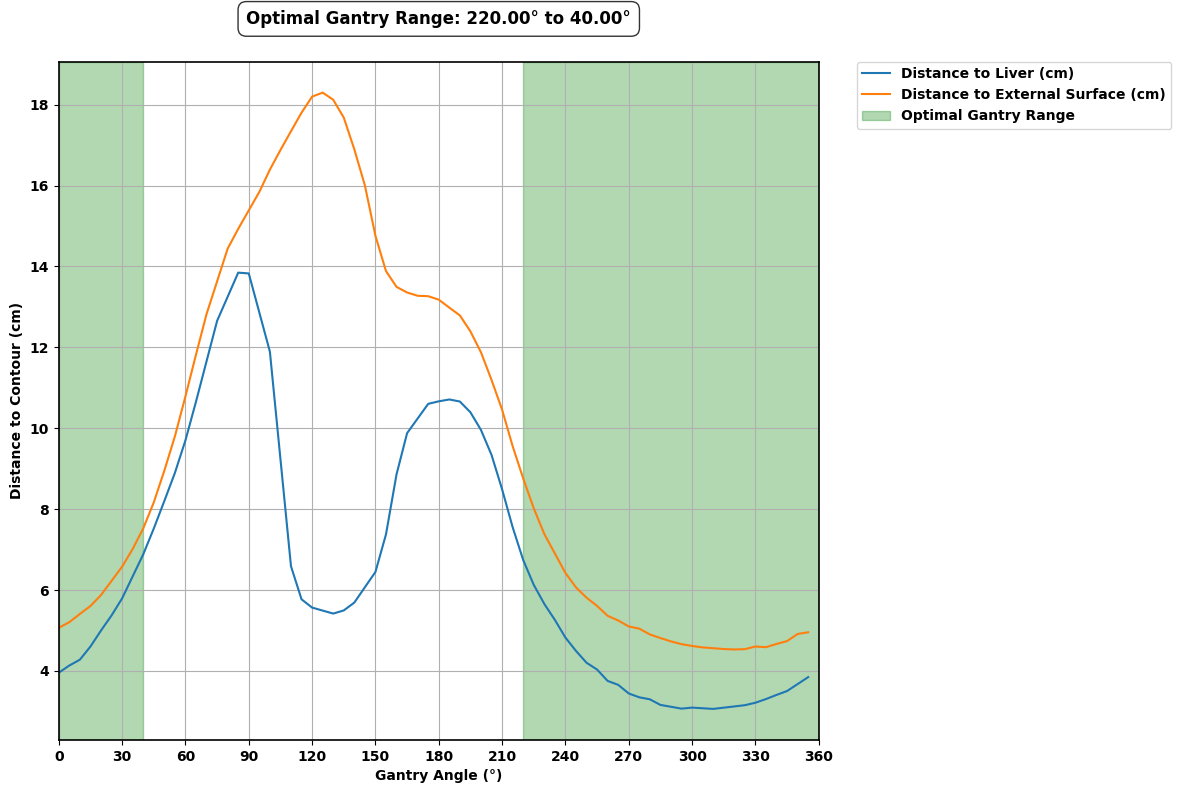

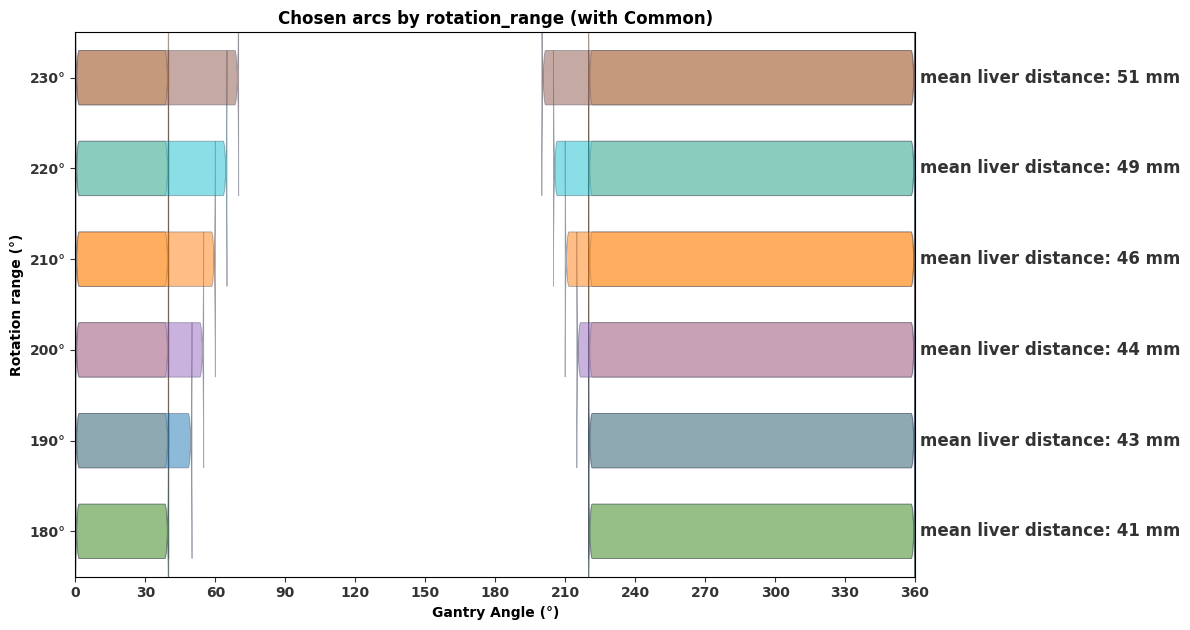

In [2]:
import numpy as np
import pydicom
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Dict, Optional
from matplotlib.patches import Wedge, FancyArrowPatch


# =========================
# DICOM ROI utilities
# =========================

def extract_structure(ds, structure_name: str) -> np.ndarray:
    """
    Extracts all 3D contour points for the specified ROI from an RT Structure Set.

    Parameters
    ----------
    ds : pydicom.dataset.FileDataset
        DICOM RT Structure Set dataset.
    structure_name : str
        ROI name to extract (ROIName in StructureSetROISequence).

    Returns
    -------
    np.ndarray
        Array of shape (N, 3) with XYZ coordinates concatenated across all contour items.

    Raises
    ------
    ValueError
        If the ROI or its contour data cannot be found.
    """
    for structure in ds.StructureSetROISequence:
        if structure.ROIName == structure_name:
            roi_number = structure.ROINumber
            break
    else:
        raise ValueError(f"{structure_name} structure not found in DICOM file")

    for contour in ds.ROIContourSequence:
        if contour.ReferencedROINumber == roi_number:
            return np.concatenate([
                np.array(cs.ContourData, dtype=float).reshape(-1, 3)
                for cs in contour.ContourSequence
            ])
    raise ValueError(f"{structure_name} contour data not found in DICOM file")


def extract_structure_center(ds, structure_name: str) -> np.ndarray:
    """
    Computes the centroid of the specified ROI (mean of all contour points).

    Parameters
    ----------
    ds : pydicom.dataset.FileDataset
        DICOM RT Structure Set dataset.
    structure_name : str
        ROI name.

    Returns
    -------
    np.ndarray
        Centroid coordinate as (x, y, z).
    """
    contour = extract_structure(ds, structure_name)
    return np.mean(contour, axis=0)


def extract_closest_slice(contour_xyz: np.ndarray, ptv_center: np.ndarray, atol: float = 1e-3) -> np.ndarray:
    """
    Extracts the 2D contour points on the axial slice closest to the PTV center z.

    Parameters
    ----------
    contour_xyz : np.ndarray
        ROI contour points of shape (N, 3).
    ptv_center : np.ndarray
        PTV center coordinate (x, y, z).
    atol : float, optional
        Absolute tolerance for z matching, by default 1e-3.

    Returns
    -------
    np.ndarray
        2D contour points on the closest axial slice (N_slice, 3) with constant z.
    """
    ptv_z = ptv_center[2]
    z_differences = np.abs(contour_xyz[:, 2] - ptv_z)
    closest_z_index = np.argmin(z_differences)
    closest_z = contour_xyz[closest_z_index, 2]
    contour_z = contour_xyz[np.isclose(contour_xyz[:, 2], closest_z, atol=atol)]
    return contour_z


# =========================
# 2D geometry
# =========================

def calculate_intersection(origin: np.ndarray, direction: np.ndarray, p1: np.ndarray, p2: np.ndarray) -> Optional[np.ndarray]:
    """
    Computes the intersection of a ray (origin + t*direction, t >= 0) with a line segment [p1, p2].

    Parameters
    ----------
    origin : np.ndarray
        Ray origin (2D).
    direction : np.ndarray
        Ray direction unit vector (2D).
    p1 : np.ndarray
        Segment start (2D).
    p2 : np.ndarray
        Segment end (2D).

    Returns
    -------
    Optional[np.ndarray]
        Intersection point (2D) if it exists with t >= 0 and within the segment (0 <= u <= 1), otherwise None.
    """
    v1 = p1 - origin
    v2 = p2 - p1
    v3 = np.array([-direction[1], direction[0]])
    dot = np.dot(v2, v3)
    if np.abs(dot) < 1e-6:
        return None
    t1 = np.cross(v2, v1) / dot
    t2 = np.dot(v1, v3) / dot
    if 0 <= t1 and 0 <= t2 <= 1:
        intersection = origin + t1 * direction
        return intersection
    return None


def calculate_distance_to_contour(ptv_center: np.ndarray, contour_z: np.ndarray, gantry_angles: np.ndarray) -> np.ndarray:
    """
    For each gantry angle, cast a ray from the PTV center and measure the distance to the first hit on the closed contour.

    Parameters
    ----------
    ptv_center : np.ndarray
        PTV center coordinate (x, y, z).
    contour_z : np.ndarray
        2D contour points on a single axial slice (N, 3).
    gantry_angles : np.ndarray
        Angles in degrees at which distances are computed.

    Returns
    -------
    np.ndarray
        Distance in the same units as coordinates for each angle; inf if no intersection is found.
    """
    distances = []
    for angle in gantry_angles:
        beam_direction = np.array([np.cos(np.radians(angle)), np.sin(np.radians(angle))], dtype=float)
        min_distance = float('inf')
        # Evaluate as a closed polyline (connect last to first)
        for i in range(len(contour_z)):
            p1 = contour_z[i, :2]
            p2 = contour_z[(i + 1) % len(contour_z), :2]
            intersection = calculate_intersection(ptv_center[:2], beam_direction, p1, p2)
            if intersection is not None:
                distance = np.linalg.norm(intersection - ptv_center[:2])
                if distance < min_distance:
                    min_distance = distance
        distances.append(min_distance)
    return np.array(distances, dtype=float)


# =========================
# Angle interval utilities
# =========================

def normalize_angle(a: float) -> float:
    """Normalizes an angle into [0, 360)."""
    return float(a % 360)


def interval_mask_on_circle(angles: np.ndarray, start: float, end: float) -> np.ndarray:
    """
    Creates a boolean mask for angles within [start, end) on a circular domain with wrap-around support.
    """
    start = normalize_angle(start)
    end = normalize_angle(end)
    if end < start:
        return (angles >= start) | (angles < end)
    else:
        return (angles >= start) & (angles < end)


def merge_angle_intervals(intervals: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
    """
    Normalizes and merges overlapping angle intervals on a circle into a minimal non-overlapping set.
    """
    norm = []
    for s, e in intervals:
        s = normalize_angle(s); e = normalize_angle(e)
        if e == s:
            continue
        if e < s:
            norm.append((s, 360.0)); norm.append((0.0, e))
        else:
            norm.append((s, e))
    if not norm:
        return []
    norm.sort(key=lambda x: x[0])
    merged = [norm[0]]
    for s, e in norm[1:]:
        ps, pe = merged[-1]
        if s <= pe:
            merged[-1] = (ps, max(pe, e))
        else:
            merged.append((s, e))
    return merged


def build_organ_forbidden_mask(angles: np.ndarray, organ_forbidden: Dict[str, List[Tuple[float, float]]]) -> np.ndarray:
    """
    Builds a boolean mask over angles that are forbidden due to organ-specific exclusion intervals.

    Parameters
    ----------
    angles : np.ndarray
        Discrete angles to mask.
    organ_forbidden : dict
        Mapping from organ/event name to a list of (start, end) angle intervals in degrees.

    Returns
    -------
    np.ndarray
        Boolean mask of shape like angles, True where forbidden.
    """
    all_intervals = [rng for lst in organ_forbidden.values() for rng in lst]
    merged = merge_angle_intervals(all_intervals)
    mask = np.zeros_like(angles, dtype=bool)
    for s, e in merged:
        mask |= interval_mask_on_circle(angles, s, e)
    return mask


# =========================
# Optimal arc search
# =========================

def find_optimal_gantry_range(angles: np.ndarray,
                              liver_distances: np.ndarray,
                              external_distances: np.ndarray,
                              rotation_range: float,
                              min_arc_length: float = 30,
                              max_external_distance: float = 120,
                              max_liver_distance: float = 60,
                              organ_forbidden_mask: Optional[np.ndarray] = None) -> Tuple[Optional[float], Optional[float], float, float]:
    """
    Finds the start/end angles for a fixed rotation range that minimize mean liver distance under constraints.

    Constraints
    -----------
    - Minimum arc length in degrees (bins respected).
    - Max distance to external surface within arc.
    - Max distance to liver within arc.
    - Organ-specific forbidden angles must be excluded.
    - Start-only forbidden rule: starts in [151, 179] are disallowed (Adjusted convention).

    Parameters
    ----------
    angles : np.ndarray
        Discretized gantry angles in degrees (assumed uniform step).
    liver_distances : np.ndarray
        Distance to liver surface for each angle (same order).
    external_distances : np.ndarray
        Distance to external surface for each angle (same order).
    rotation_range : float
        Arc span in degrees.
    min_arc_length : float, optional
        Minimum allowable arc length, by default 30.
    max_external_distance : float, optional
        Initial maximum allowed external distance (mm), by default 120.
    max_liver_distance : float, optional
        Maximum allowed liver distance (mm), by default 60.
    organ_forbidden_mask : Optional[np.ndarray], optional
        Boolean mask of forbidden angles, by default None.

    Returns
    -------
    Tuple[Optional[float], Optional[float], float, float]
        (best_start_deg, best_end_deg, min_mean_liver_distance_mm, final_external_limit_mm).
    """
    best_start = None
    best_end = None
    min_avg_distance = float('inf')
    current_external_limit = max_external_distance

    # Start-only forbidden window (Adjusted convention: starts in 151–179° are not allowed)
    def is_forbidden_start(a: float) -> bool:
        a = a % 360
        return 151 <= a <= 179

    # Angle step width (assumes equal spacing)
    step = np.diff(angles[:2])[0] if len(angles) >= 2 else 5.0
    min_arc_bins = int(np.ceil(min_arc_length / step))

    if organ_forbidden_mask is None:
        organ_forbidden_mask = np.zeros_like(angles, dtype=bool)

    while current_external_limit <= 400:
        for start in angles.astype(int):
            # Start-only forbidden check
            if is_forbidden_start(start):
                continue

            end = (start + rotation_range) % 360

            # Interval extraction (wrap-aware)
            if end < start:
                idx = (angles >= start) | (angles < end)
            else:
                idx = (angles >= start) & (angles < end)

            # Exclude arcs intersecting case-specific forbidden angles
            if np.any(organ_forbidden_mask & idx):
                continue

            # Enforce minimum arc length in bins
            if np.count_nonzero(idx) < min_arc_bins:
                continue

            range_liver = liver_distances[idx]
            range_external = external_distances[idx]

            # Distance constraints
            if np.any(range_external > current_external_limit) or np.any(range_liver > max_liver_distance):
                continue

            if len(range_liver) > 0:
                avg_distance = float(np.mean(range_liver))
                arc_length = (end - start) % 360
                if arc_length >= min_arc_length and avg_distance < min_avg_distance:
                    min_avg_distance = avg_distance
                    best_start = float(start)
                    best_end = float(end)

        if best_start is not None and best_end is not None:
            break
        current_external_limit += 10.0

    return best_start, best_end, min_avg_distance, current_external_limit


# =========================
# Data preparation
# =========================

def prepare_distance_dataframe(dicom_file_path: str,
                               liver_name: str = 'Liver',
                               external_name: str = 'External',
                               ptv_name: str = 'PTV1',
                               angle_step: float = 5.0,
                               adjust_by_col90: bool = True) -> pd.DataFrame:
    """
    Loads an RTSS file and computes ray-cast distances to Liver and External contours across gantry angles.

    Steps
    -----
    - Read contours for specified ROIs.
    - Select axial slice closest to PTV center z for each ROI.
    - For discrete angles, compute distance from PTV center to contour along the ray.
    - Optionally rotate angle convention by -90 degrees (COL=90 adjustment).
    - Interpolate inf values.
    - Return a sorted DataFrame keyed by adjusted gantry angle.

    Parameters
    ----------
    dicom_file_path : str
        Path to the RT Structure Set DICOM file.
    liver_name : str, optional
        ROI name for the liver, by default 'Liver'.
    external_name : str, optional
        ROI name for the external body surface, by default 'External'.
    ptv_name : str, optional
        ROI name for PTV center extraction, by default 'PTV1'.
    angle_step : float, optional
        Angle sampling step in degrees, by default 5.0.
    adjust_by_col90 : bool, optional
        If True, shift angles by -90 degrees (mod 360), by default True.

    Returns
    -------
    pd.DataFrame
        Columns: Adjusted_Gantry_Angle, Liver_Distance, External_Distance.
        Distances are in the same units as the DICOM coordinates (often mm).
    """
    ds = pydicom.dcmread(dicom_file_path)
    liver_contour = extract_structure(ds, liver_name)
    external_contour = extract_structure(ds, external_name)
    ptv_center = extract_structure_center(ds, ptv_name)

    liver_contour_z = extract_closest_slice(liver_contour, ptv_center)
    external_contour_z = extract_closest_slice(external_contour, ptv_center)

    # Reference info (minimum distance)
    d_liver_center = cdist([ptv_center], liver_contour_z).flatten()
    d_external_center = cdist([ptv_center], external_contour_z).flatten()
    print(f"Minimum distance from liver surface to PTV center: {np.min(d_liver_center)/10:.2f} cm")
    print(f"Minimum distance from external surface to PTV center: {np.min(d_external_center)/10:.2f} cm")

    gantry_angles = np.arange(0, 360, angle_step, dtype=float)
    liver_distances = calculate_distance_to_contour(ptv_center, liver_contour_z, gantry_angles)
    external_distances = calculate_distance_to_contour(ptv_center, external_contour_z, gantry_angles)

    adjusted_gantry_angles = ((gantry_angles - 90) % 360) if adjust_by_col90 else gantry_angles

    df_sorted = pd.DataFrame({
        'Adjusted_Gantry_Angle': adjusted_gantry_angles,
        'Liver_Distance': liver_distances,
        'External_Distance': external_distances
    }).sort_values(by='Adjusted_Gantry_Angle').reset_index(drop=True)

    # Interpolate infinities
    df_sorted['Liver_Distance'] = df_sorted['Liver_Distance'].replace([np.inf, -np.inf], np.nan).interpolate(method='linear', limit_direction='both')
    df_sorted['External_Distance'] = df_sorted['External_Distance'].replace([np.inf, -np.inf], np.nan).interpolate(method='linear', limit_direction='both')

    # Debug output (means)
    print(f"Mean projected distance from liver surface to PTV center: {np.mean(df_sorted['Liver_Distance'])/10:.2f} cm")
    print(f"Mean projected distance from external surface to PTV center: {np.mean(df_sorted['External_Distance'])/10:.2f} cm")

    return df_sorted


# =========================
# Evaluate multiple rotation spans
# =========================

def evaluate_multiple_rotation_ranges(df_sorted: pd.DataFrame,
                                      rotation_ranges: List[float] = (150,160,170,180,190,200,210,220),
                                      min_arc_length: float = 30,
                                      max_external_distance: float = 120,
                                      max_liver_distance: float = 80,
                                      organ_forbidden: Optional[Dict[str, List[Tuple[float, float]]]] = None) -> pd.DataFrame:
    """
    Evaluates optimal arcs for several rotation ranges and summarizes results.

    Parameters
    ----------
    df_sorted : pd.DataFrame
        Output from prepare_distance_dataframe.
    rotation_ranges : list of float, optional
        Candidate arc spans in degrees, by default (150,160,...,220).
    min_arc_length : float, optional
        Minimum arc length in degrees, by default 30.
    max_external_distance : float, optional
        Maximum allowed external distance (mm), by default 120.
    max_liver_distance : float, optional
        Maximum allowed liver distance (mm), by default 80.
    organ_forbidden : dict, optional
        Mapping of organ/event to angle intervals, by default None.

    Returns
    -------
    pd.DataFrame
        One row per rotation_range with columns:
        rotation_range, best_start_deg, best_end_deg,
        min_avg_liver_distance_mm, final_external_limit_mm.
    """
    results = []

    angles = df_sorted['Adjusted_Gantry_Angle'].to_numpy()
    liver = df_sorted['Liver_Distance'].to_numpy()
    external = df_sorted['External_Distance'].to_numpy()

    # Build case-specific forbidden mask (optional)
    organ_mask = build_organ_forbidden_mask(angles, organ_forbidden) if organ_forbidden else np.zeros_like(angles, dtype=bool)

    for rr in rotation_ranges:
        best_start, best_end, min_avg, final_limit = find_optimal_gantry_range(
            angles, liver, external,
            rotation_range=rr,
            min_arc_length=min_arc_length,
            max_external_distance=max_external_distance,
            max_liver_distance=max_liver_distance,
            organ_forbidden_mask=organ_mask
        )
        results.append({
            'rotation_range': rr,
            'best_start_deg': best_start,
            'best_end_deg': best_end,
            'min_avg_liver_distance_mm': min_avg,
            'final_external_limit_mm': final_limit
        })

    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='min_avg_liver_distance_mm', na_position='last').reset_index(drop=True)
    return df_results


# =========================
# Visualization (angle vs distance + exclusion bands)
# =========================

def plot_distances_vs_angle(df_sorted: pd.DataFrame,
                            best_start_angle: Optional[float],
                            best_end_angle: Optional[float],
                            organ_forbidden: Optional[Dict[str, List[Tuple[float, float]]]] = None):
    """
    Plots distances to liver and external surface vs. adjusted gantry angle, with organ exclusion and optimal arc highlight.
    """
    plt.figure(figsize=(12, 8))
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_color('black')
        ax.spines[side].set_linewidth(1.2)

    plt.plot(df_sorted['Adjusted_Gantry_Angle'], df_sorted['Liver_Distance']/10,
         label='Distance to Liver (cm)')
    plt.plot(df_sorted['Adjusted_Gantry_Angle'], df_sorted['External_Distance']/10,
         label='Distance to External Surface (cm)')

    # Draw organ/event-specific exclusion bands (color-coded)
    if organ_forbidden:
        colors = {
            'Collision': 'red',
            'SpinalCord': 'cyan',
            'Stomach': 'purple',
            'Kidney_R': 'green',
            'Kidney_L': 'olive',
            'Duodenum': 'yellow',
            'Large_Bowel': 'pink'
        }
        for i, (name, ranges) in enumerate(organ_forbidden.items()):
            col = colors.get(name, 'gray')
            merged = merge_angle_intervals(ranges)
            for j, (s, e) in enumerate(merged):
                if e > s:
                    plt.axvspan(s, e, color=col, alpha=0.15,
                                label=name if j == 0 else None)

    # Highlight optimal arc (wrap-aware)
    if best_start_angle is not None and best_end_angle is not None:
        if best_end_angle > best_start_angle:
            plt.axvspan(best_start_angle, best_end_angle, alpha=0.3, color='green', label='Optimal Gantry Range')
        else:
            plt.axvspan(best_start_angle, 360, alpha=0.3, color='green', label='Optimal Gantry Range')
            plt.axvspan(0, best_end_angle, alpha=0.3, color='green')

        optimal_range_text = f"Optimal Gantry Range: {best_start_angle:.2f}° to {best_end_angle:.2f}°"
        plt.text(0.5, 1.05, optimal_range_text, ha='center', va='bottom',
                 transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.xlabel('Gantry Angle (°)', weight='bold')
    plt.ylabel('Distance to Contour (cm)', weight='bold')
    plt.xlim(0, 360)
    plt.xticks(np.arange(0, 361, 30))
    plt.xticks(fontweight='bold', fontsize=10)
    plt.yticks(fontweight='bold', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 10, 'weight': 'bold'})
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_arc_matrix_by_range(
    df_results: pd.DataFrame,
    angle_step: float = 5.0,
    title: str = 'Chosen arcs by rotation_range (with Common)'
):
    """
    Visualizes chosen arcs per rotation_range as horizontal bands and shows the common overlap across all ranges.

    Notes
    -----
    - Uses discrete angles with wrap-aware span rendering.
    - Annotates mean liver distance on the right margin for each row.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch

    # Style
    plt.rcParams.update({
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'axes.grid': False,
        'xtick.color': '#333333',
        'ytick.color': '#333333',
        'axes.edgecolor': 'black',
        'axes.titleweight': 'semibold'
    })

    # Drop rows without valid arcs
    df_ok = df_results.dropna(subset=['best_start_deg', 'best_end_deg']).copy()
    if df_ok.empty:
        print('No arcs to plot.')
        return

    # For each rotation_range, keep representative row (smallest mean)
    grp = (
        df_ok
        .sort_values(['rotation_range', 'min_avg_liver_distance_mm'])
        .groupby('rotation_range', as_index=False)
        .first()
        .sort_values('rotation_range')
    )

    # Compute intersection (common area) across ranges using discrete angles
    angles = np.arange(0, 360, angle_step, dtype=float)
    mask_all = np.ones_like(angles, dtype=bool)
    for _, row in grp.iterrows():
        s = float(row['best_start_deg']); e = float(row['best_end_deg'])
        if e >= s:
            mask = (angles >= s) & (angles < e)
        else:
            mask = (angles >= s) | (angles < e)
        mask_all &= mask

    def mask_to_segments(angles, mask, step):
        segs = []
        if not np.any(mask):
            return segs
        idx = np.where(mask)[0]
        splits = np.where(np.diff(idx) > 1)[0]
        starts = np.insert(idx[splits + 1], 0, idx[0])
        ends = np.append(idx[splits], idx[-1])
        for st, en in zip(starts, ends):
            segs.append((angles[st], angles[en] + step))
        # Handle wrap-join when first/last connect
        if mask[0] and mask[-1] and len(segs) >= 2:
            first_s, first_e = segs[0]
            last_s, last_e = segs[-1]
            segs = [(last_s, first_e if first_e <= 360 else 360)]
        return segs

    common_segments = mask_to_segments(angles, mask_all, angle_step)

    # Plot setup
    palette = ['#2ca25f', '#1f77b4', '#9467bd', '#ff7f0e', '#17becf', '#8c564b', '#e377c2', '#7f7f7f']
    edge_color = '#4c566a'
    arc_alpha = 0.5
    common_color = '#ff9f1a'
    common_alpha = 0.35

    fig, ax = plt.subplots(figsize=(12, 0.9 * len(grp) + 1))
    ax.set_xlim(0, 360)
    ax.set_ylim(0, len(grp))

    # Y-axis
    ax.set_yticks(np.arange(len(grp)) + 0.5)
    ax.set_yticklabels([f'{int(rr)}°' for rr in grp['rotation_range']])
    ax.set_ylabel('Rotation range (°)', weight='bold')

    # X-axis
    ax.set_xlabel('Gantry Angle (°)', weight='bold')
    ax.set_xticks(np.arange(0, 361, 30))
    ax.set_title(title)

    for t in ax.get_xticklabels(): t.set_fontweight('bold')
    for t in ax.get_yticklabels(): t.set_fontweight('bold')

    # Utility to draw spans (wrap-aware)
    def draw_span(ax, s, e, y0, y1, color, alpha, edge='#00000000'):
        # Main body
        rect = FancyBboxPatch(
            (s, y0),
            (e - s) if e >= s else (360 - s),
            y1 - y0,
            boxstyle="round,pad=0,rounding_size=1.6",
            linewidth=0.6,
            edgecolor=edge,
            facecolor=color,
            alpha=alpha
        )
        ax.add_patch(rect)
        # Wrapped segment
        if e < s:
            rect2 = FancyBboxPatch(
                (0, y0),
                e - 0,
                y1 - y0,
                boxstyle="round,pad=0,rounding_size=1.6",
                linewidth=0.6,
                edgecolor=edge,
                facecolor=color,
                alpha=alpha
            )
            ax.add_patch(rect2)

    # Draw common band behind each row
    for row_idx in range(len(grp)):
        y0, y1 = row_idx + 0.2, row_idx + 0.8
        for s, e in common_segments:
            draw_span(ax, s, e, y0, y1, common_color, common_alpha, edge='#00000000')

    # Draw best arc per rotation_range; annotate mean liver distance on right
    for i, row in enumerate(grp.itertuples(index=False)):
        rr = int(row.rotation_range)
        s = float(row.best_start_deg); e = float(row.best_end_deg)
        color = palette[i % len(palette)]
        y0, y1 = i + 0.2, i + 0.8

        # Arc band
        draw_span(ax, s, e, y0, y1, color, arc_alpha, edge=edge_color)

        # Mean liver distance (mm)
        mean_mm = float(row.min_avg_liver_distance_mm)
        label_long = f"mean liver distance: {mean_mm:.0f} mm"

        # Note on right margin
        ax.text(
            362, (y0 + y1) / 2.0, label_long,
            ha='left', va='center', fontsize=12, color='#333333',
            weight='bold', transform=ax.transData, clip_on=False
        )

    # Reserve right margin for labels
    ax.set_xlim(0, 360)
    fig.subplots_adjust(right=0.80)  # keep 20% right margin
    fig.tight_layout()

    plt.show()


# =========================
# Example usage
# =========================

if __name__ == "__main__":
    dicom_file_path = "RSphantom.dcm"
    min_arc_length = 30    # Minimum arc length (deg)
    max_external_distance = 120  # Max distance from external surface (mm)
    max_liver_distance = 120     # Max distance from liver surface (mm)

    df_sorted = prepare_distance_dataframe(dicom_file_path)

    # Case-specific collision/organ exclusions (optional; leave empty to skip)
    organ_forbidden = {
        # "Collision": [(50, 125)],
        # "SpinalCord": [(125, 150)],
        # "Stomach": [(0, 50)],
        # "Kidney_R": [(90, 170)],
        # "Kidney_L": [(90, 170)],
        # "Duodenum": [(90, 170)],
        # "Large_Bowel": [(90, 170)],
    }

    rotation_ranges = [180, 190, 200, 210, 220, 230]
    df_results = evaluate_multiple_rotation_ranges(
        df_sorted,
        rotation_ranges=rotation_ranges,
        min_arc_length=min_arc_length,
        max_external_distance=max_external_distance,
        max_liver_distance=max_liver_distance,
        organ_forbidden=organ_forbidden
    )

    print("Optimal arc candidates per rotation_range (sorted by mean liver distance):")
    print(df_results)

    # Visualize top solution (first row)
    if len(df_results) > 0 and pd.notna(df_results.loc[0, 'best_start_deg']):
        best_start = float(df_results.loc[0, 'best_start_deg'])
        best_end = float(df_results.loc[0, 'best_end_deg'])
        # Angle-distance plot
        plot_distances_vs_angle(df_sorted, best_start, best_end, organ_forbidden=organ_forbidden)
        # Load DICOM if needed for additional geometry
        ds = pydicom.dcmread(dicom_file_path)

    plot_arc_matrix_by_range(
        df_results,
        angle_step=5.0,
        title='Chosen arcs by rotation_range (with Common)'
    )
